# Jessica's Charts

In [1]:
# !pip install altair_saver --quiet

## Loading dependencies/libraries

In [2]:
import sys
import os
import altair as alt
import pandas as pd
from toolz.curried import pipe
from altair_saver import save

# # Create a new data transformer that stores the files in a directory
def json_dir(data, data_dir='altairdata'):
    os.makedirs(data_dir, exist_ok=True)
    return pipe(data, alt.to_json(filename=data_dir + '/{prefix}-{hash}.{extension}') )

# # Register and enable the new transformer
alt.data_transformers.register('json_dir', json_dir)
alt.data_transformers.enable('json_dir')

sys.path.append('..')
from scripts import wrangle_and_clean as wac

# Handle large data sets (default shows only 5000)
# See here: https://altair-viz.github.io/user_guide/data_transformers.html
alt.data_transformers.disable_max_rows()

alt.renderers.enable('jupyterlab')

RendererRegistry.enable('jupyterlab')

## Load & Wrangle Data

In [3]:
mxmh = wac.clean_data("../data/raw/mxmh_survey_results.csv")
mxmh.head()

,Timestamp,Age,Primary streaming service,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,...,Frequency_K_pop_numeric,Frequency_Latin_numeric,Frequency_Lofi_numeric,Frequency_Metal_numeric,Frequency_Pop_numeric,Frequency_R&B_numeric,Frequency_Rap_numeric,Frequency_Rock_numeric,Frequency_Video_game_music_numeric,Genre Diversity Score
0,2022-08-27 19:29:02,18.0,Spotify,3.0,Yes,Yes,Yes,Latin,Yes,Yes,...,3,3,1,0,3,2,3,0,2,10
1,2022-08-27 19:57:31,63.0,Pandora,1.5,Yes,No,No,Rock,Yes,No,...,1,2,1,0,2,2,1,3,1,13
2,2022-08-27 21:28:18,18.0,Spotify,4.0,No,No,No,Video game music,No,Yes,...,3,0,2,2,1,0,1,1,3,10
3,2022-08-27 21:40:40,61.0,YouTube Music,2.5,Yes,No,Yes,Jazz,Yes,Yes,...,2,3,2,0,2,2,0,0,0,9
4,2022-08-27 21:54:47,18.0,Spotify,4.0,Yes,No,No,R&B,Yes,No,...,3,2,2,0,2,3,3,0,1,10


In [4]:
mxmh_scores = mxmh.melt(id_vars=["Timestamp", "Age", "Music effects"], 
                     value_vars=["Anxiety", "Depression", "Insomnia", "OCD"], 
                     var_name="Mental Health Condition", 
                     value_name="Self-report Score")

music_effects_ordered = ['Improve', 'No effect', 'Worsen', 'No response']

mxmh_scores["Music effects"] = pd.Categorical(mxmh_scores["Music effects"], 
                                              categories=music_effects_ordered, 
                                              ordered=True)

mxmh_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2916 entries, 0 to 2915
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Timestamp                2916 non-null   datetime64[ns]
 1   Age                      2916 non-null   float64       
 2   Music effects            2916 non-null   category      
 3   Mental Health Condition  2916 non-null   object        
 4   Self-report Score        2916 non-null   float64       
dtypes: category(1), datetime64[ns](1), float64(2), object(1)
memory usage: 94.3+ KB


## Aesthetic Settings

In [5]:
# === COLOR PALETTE === #
okabe_ito_palette = [
    "#009E73",  # Green
    "#0072B2",  # Blue
    "#56B4E9",  # Sky Blue
    "#F0E442",  # Yellow
    "#E69F00",  # Orange
    "#D55E00",  # Vermillion
    "#CC79A7",  # Pink
    '#23338A',  # Dark Blue [colour blind safe addition]
]

### === Color and Order for Music Effects === ###
# music_effects_ordered = ['Improve', 'No effect', 'Worsen', 'No response']
# effect_colors = ["mediumaquamarine", "khaki", "orange", "grey"]
effect_colors = ["#009E73", "#F0E442", "#E69F00", "grey"]
effect_color_scale = alt.Scale(domain=music_effects_ordered, range=effect_colors)

### === Color and Order for Mental Health === ###
mental_health_ordered = ['Anxiety', 'Depression', 'Insomnia', 'OCD']
health_colors = ["#009E73", "#23338A", "#E69F00", "#F0E442"]
health_color_scale = alt.Scale(domain=mental_health_ordered, range=health_colors)

In [26]:
# === FONT SETTING ===
font_choice = "Segoe UI"

legend_configuration = {"titleFontSize": 15,
    "labelFontSize": 15,
    "fillColor": '#F5F5F5',
    "padding": 10,
    "cornerRadius": 10,
    "labelFont": font_choice,
    "labelSeparation": 5,
    "titleFont": font_choice,
    "titleLimit": 240
}

title_configuration = {
    "fontSize": 25,
    "anchor": "middle", 
    "font": font_choice,
    "subtitlePadding": 10,
    "subtitleFont": font_choice,
    "subtitleColor": "grey10",
    "subtitleFontSize": 17
}

axis_configuration = {
    "labelFont": font_choice,
    "titleFont": font_choice,
    "labelFontSize": 15,
    "titleFontSize": 18
}

header_configuration = {
    "labelFont": font_choice,
    "titleFont": font_choice,
    "labelFontSize": 15,
    "titleFontSize": 18
}

## Question 1: What is the distribution of self-reported mental health scores based on opinions of music on mental health?

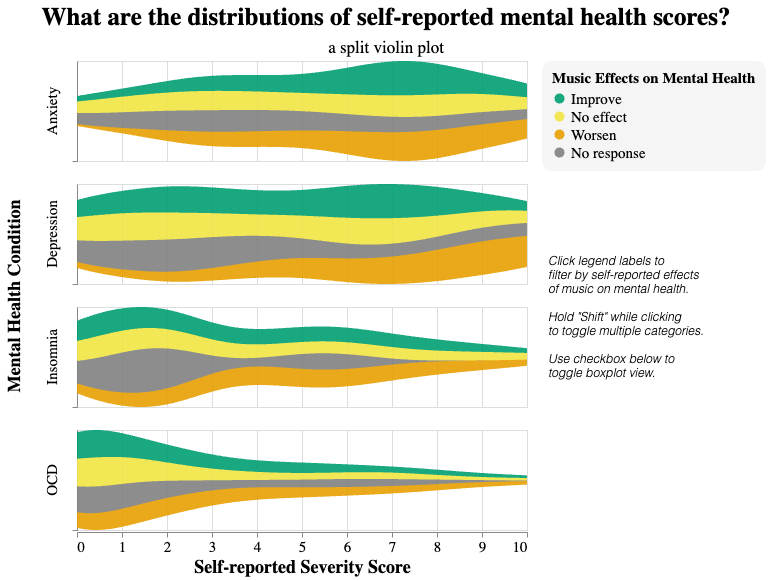

In [34]:
### WIDGETS ###
selection = alt.selection_point(fields=["Music effects"], bind="legend", empty=True)

bind_checkbox = alt.binding_checkbox(name="Show Boxplot: ")
param_checkbox = alt.param(bind=bind_checkbox)

### BOX PLOT ###
boxplot = (
    alt.Chart(mxmh_scores)
    .mark_boxplot(color="black", opacity=0.4, size=30)
    .encode(
        alt.X("Self-report Score:Q", title="Self-reported Severity Score"),
        opacity=alt.when(param_checkbox).then(alt.value(0.7)).otherwise(alt.value(0)),
    )
    .add_params(param_checkbox)
    .properties(width=450)
)

### VIOLIN PLOT ###
violin = (
    alt.Chart(mxmh_scores)
    .transform_density(
        "Self-report Score",
        as_=["Self-report Score", "density"],
        extent=[0, 10],
        groupby=["Mental Health Condition:N", "Music effects"],
    )
    .mark_area(opacity=0.9, orient="vertical", interpolate="monotone", tooltip=True)
    .encode(
        x=alt.X("Self-report Score:Q", title="Self-reported Severity Score"),
        y=alt.Y(
            "density:Q",
            stack="center",
            impute=None,
            title=None,
            sort=alt.EncodingSortField(field="density"),
            scale=alt.Scale(
                nice=False,
                zero=True,
            ),
            axis=alt.Axis(labels=False, values=[0], grid=False, ticks=True),
        ),
        color=alt.condition(
            selection,
            alt.Color(
                "Music effects:O",
                title="Music Effects on Mental Health",
                scale=effect_color_scale,
                sort=['Improve', 'No effect', 'Worsen', 'No response'],
                legend=alt.Legend(orient='none',legendX=465, legendY=0)
            ),
            alt.value("lightgrey"),
        ),
    )
    .properties(width=450, height=100)
    .add_params(selection)
)

### === NOTE === ###
note = alt.Chart({'values': [{}]}).mark_text(
    text=[
        'Click legend labels to', 'filter by self-reported effects', ' of music on mental health.', '',
        'Hold "Shift" while clicking', 'to toggle multiple categories.', '', 
        'Use checkbox below to ', 'toggle boxplot view.',
    ],
    align='left',
    baseline='middle',
    fontSize=12,
    y=200,
    x=-100,
    fontWeight='lighter',
    fontStyle= 'italic',
)

### FINAL CHART 1 ###
chart1 = (
    alt.layer(violin, boxplot)
    .facet(row=alt.Row("Mental Health Condition"))
    .resolve_scale(y=alt.ResolveMode("independent"))
    # .properties(
    #     title={
    #         "text": [
    #             "What are the distributions of self-reported mental health scores?",
    #             # "...",
    #         ],
    #         "subtitle": [
    #             "a split violin plot"
    #         ],
    #     }
    # )
    # .configure_legend(**legend_configuration)
    # .configure_title(**title_configuration)
    # .configure_axis(**axis_configuration)
    # .configure_header(**header_configuration)
)
chart1

final_chart1 = alt.hconcat(chart1, note
).properties(
        title={
            "text": [
                "What are the distributions of self-reported mental health scores?",
                # "...",
            ],
            "subtitle": [
                "a split violin plot"
            ],
        }
    ).configure_legend(**legend_configuration).configure_title(**title_configuration).configure_axis(**axis_configuration).configure_header(**header_configuration)

final_chart1
# save(chart1, "outputs/chart1.json")



---




**Summary of tasks:**

This visualization was designed to get an overview of the **distribution** of the self-reported mental health scores, split by a self-reported score of whether music `Improves`, has `No effect`, or `Worsens` mental health (or they did not respond). Summarize the tasks it was designed to address and how/whether the visualizations you chose accomplish (or not accomplish) that task.


## Question 2: What are the response patterns for self-reported mental health?

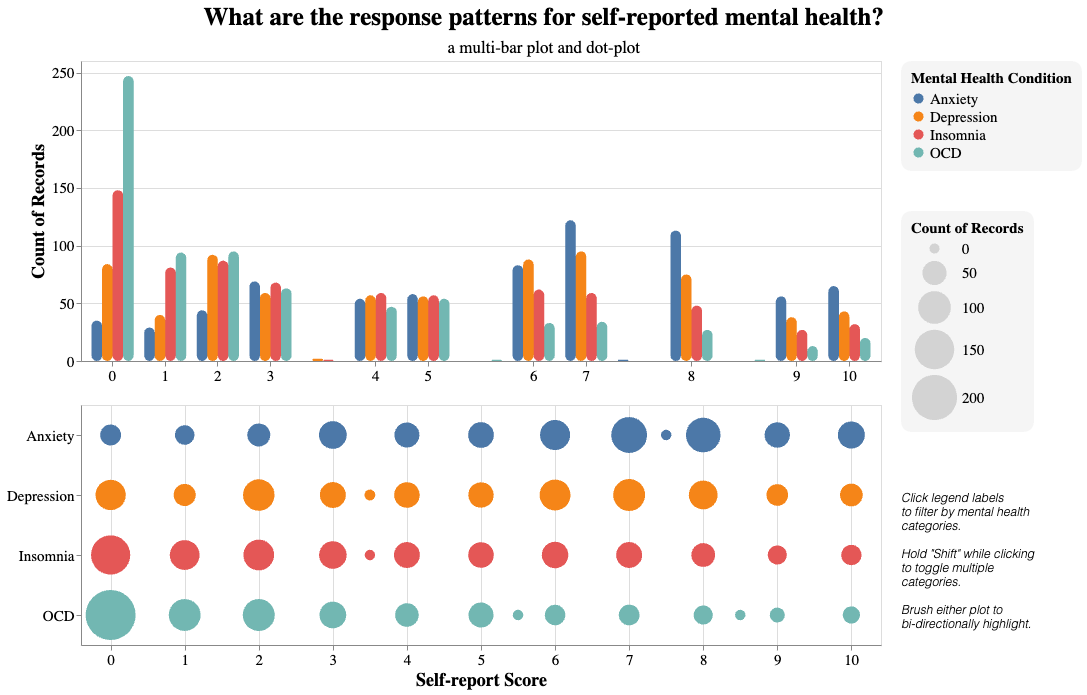

In [8]:
### === Interactions === ###
brush = alt.selection_interval()
selection = alt.selection_point(fields=['Mental Health Condition'], bind='legend')


### === Multi-bar Plot === ###
multibar = alt.Chart(mxmh_scores).add_params(
    brush, selection
).mark_bar(cornerRadius=7).encode(
    x=alt.X('Self-report Score:O', title=None).axis(labelAngle=0, tickMinStep=0.5, values=list(range(0, 11, 1))),
    xOffset="Mental Health Condition:N",
    y='count():Q',
    opacity = alt.condition(selection, alt.value(1), alt.value(0)), 
    color=alt.when(brush).then(alt.Color("Mental Health Condition:N",
                                         legend=alt.Legend(orient='none',
                                                           legendX=820,
                                                           legendY=0))
                              ).otherwise(alt.value("lightgray")),
    tooltip=["Mental Health Condition", 'Self-report Score:O', "count()"]
).properties(width=800, height=300)

### === DOT-PLOT === ###
dotplot = alt.Chart(mxmh_scores).add_params(
    brush, selection
).mark_circle(opacity=0.8).encode(
    x=alt.X('Self-report Score', title="Self-report Score", scale=alt.Scale(domain=[-0.4, 10.4])).axis(tickMinStep=0.5, values=list(range(0, 11, 1))),
    y=alt.Y('Mental Health Condition:N', title=None),
    color=alt.when(brush).then("Mental Health Condition:N").otherwise(alt.value("lightgray")),
    opacity = alt.condition(selection, alt.value(1), alt.value(0)), 
    size = alt.Size("count():Q", scale=alt.Scale(rangeMin=100, rangeMax=2500),
                    legend=alt.Legend(orient='none',
                                      legendX=820,
                                      legendY=150)
                   ),
    tooltip=["Mental Health Condition", "Self-report Score", "count()"]
).properties(width=800, height=240)

### === NOTE === ###
note = alt.Chart({'values': [{}]}).mark_text(
    text=[
        'Click legend labels ', 'to filter by mental health', 'categories.', '',
        'Hold "Shift" while clicking', 'to toggle multiple', ' categories.', '', 
        'Brush either plot to ', 'bi-directionally highlight.',
    ],
    align='left',
    baseline='bottom',
    fontSize=12,
    y=100,
    x=820,
    fontWeight='lighter',
    fontStyle= 'italic',
)

### === DOT-PLOT & NOTE === ###
dotplot_note = alt.layer(dotplot, note)

### === FINAL CHART #2 ===###
chart2 = alt.vconcat(multibar, dotplot_note
).properties(
    title={
        "text": ["What are the response patterns for self-reported mental health?"],
        "subtitle": ["a multi-bar plot and dot-plot"]
    }
).resolve_scale(
    x='shared'
).configure_legend(
    **legend_configuration
).configure_title(
    **title_configuration
).configure_axis(
    **axis_configuration
).configure_header(
    **header_configuration
)

chart2.show()

# save(chart2, "outputs/chart2.json")

- For the visualization below, select the **Mental Health Condition** to look at a condition of interest.
- Use `shift` + click to select multiple categories.

For the visualization below, drag your cursor across the screen to highlight sections of the histogram and dot-chart.

## Question 3: Can we group individuals into clusters based on their music preferences and mental health scores?

In [9]:
# mxmh.head()

### 3.1

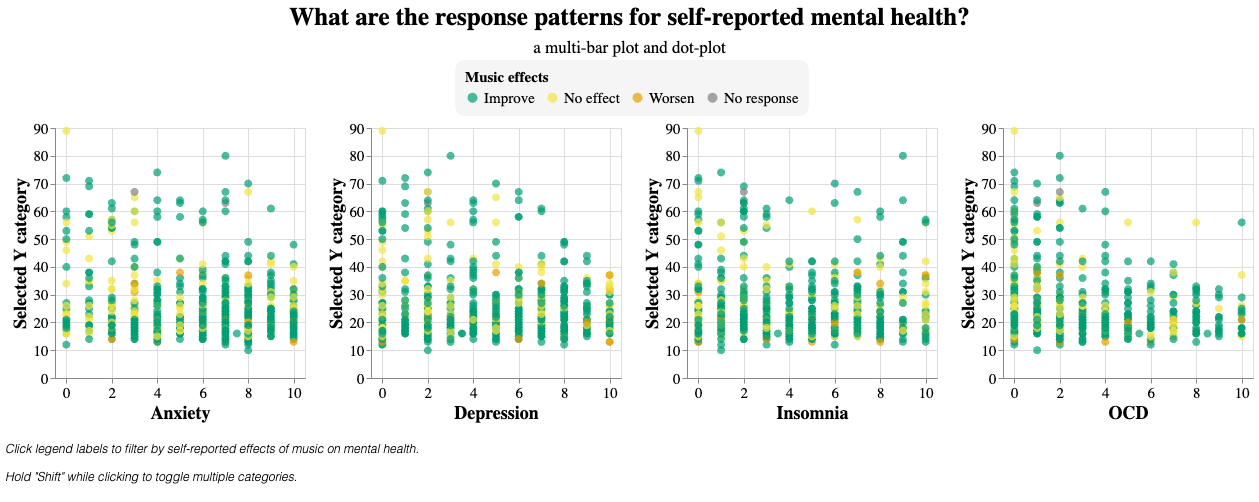

In [46]:
### === WIDGETS & INTERACTIONS === ###
dropdown_y = alt.binding_select(
    options=["Age", "BPM"],
    name='Y-axis column '
)

# dropdown for Y column
ycol_param = alt.param(
    value='Age',
    bind=dropdown_y
)

click = alt.selection_point(empty=False)
hover = alt.selection_point(on='mouseover', empty=False)
brush = alt.selection_interval()
selection_me = alt.selection_point(fields=['Music effects'], bind='legend')


# y_axis_selection = alt.binding_select(options=['Age', 'BPM'], name='Y-axis column: ')
# y_axis_variable = alt.param(bind=y_axis_selection, value='Age')

### CHART ###

chart3e = alt.Chart(mxmh).mark_circle(opacity=0.7).encode(
    x=alt.X(scale=alt.Scale(domain=[-0.5, 10.5])),
    y=alt.Y('y:Q', title="Selected Y category"),
    color=alt.when(brush).then(alt.Color("Music effects:N", scale=effect_color_scale)).otherwise(alt.value("lightgray")),
    tooltip=alt.Tooltip(['Age', 'Anxiety', 'Depression', 'Insomnia', 'OCD', "Music effects"]),
    size=alt.when(hover).then(alt.value(800)),
    opacity=alt.when(selection_me).then(alt.value(0.7)).otherwise(alt.value(0.01)),
).properties(
    width=250,
    height=250
).transform_calculate(
    y=f'datum[{ycol_param.name}]',
).add_params(
    hover, brush, ycol_param, selection_me
)

chart3e_anx = chart3e.encode(
    x=alt.X('Anxiety:Q', scale=alt.Scale(domain=[-0.5, 10.5])),
)

chart3e_dep = chart3e.encode(
    x=alt.X('Depression:Q', scale=alt.Scale(domain=[-0.5, 10.5]))
)

chart3e_ins = chart3e.encode(
    x=alt.X('Insomnia:Q', scale=alt.Scale(domain=[-0.5, 10.5]))
)

chart3e_ocd = chart3e.encode(
    x=alt.X('OCD:Q', scale=alt.Scale(domain=[-0.5, 10.5]))
)

### === NOTE === ###
note = alt.Chart({'values': [{}]}).mark_text(
    text=[
        'Click legend labels to filter by self-reported effects of music on mental health.', '',
        'Hold "Shift" while clicking to toggle multiple categories.', '',
    ],
    align='left',
    baseline='middle',
    fontSize=12,
    y=0,
    x=-50,
    fontWeight='lighter',
    fontStyle= 'italic',
)

### FINAL VIZ ###
chart3_all = (chart3e_anx | chart3e_dep | chart3e_ins | chart3e_ocd)
# ).configure_legend(
#     **legend_configuration
# ).properties(
#     title={
#         "text": ["Can individuals be clustered based on their music preferences and mental health scores?", "..."],
#         "subtitle": ["..."]
#     }
# ).configure_legend(
#     direction='horizontal',
#     orient='none',
#     legendX=400,
#     legendY= -68,
#     **legend_configuration
# ).configure_title(
#     **title_configuration
# ).configure_axis(
#     **axis_configuration
# )

chart3_final = alt.vconcat(chart3_all, note
).properties(
    title={
        "text": ["What are the response patterns for self-reported mental health?"],
        "subtitle": ["a multi-bar plot and dot-plot"]
    }
).resolve_scale(
    x='shared'
).configure_legend(
    direction='horizontal',
    orient='none',
    legendX=400,
    legendY= -68,
    **legend_configuration
).configure_title(
    **title_configuration
).configure_axis(
    **axis_configuration
).configure_header(
    **header_configuration
)

chart3_final

# save(chart3e_all, "outputs/chart3ii.json")

### 3.2

In [11]:
dropdown_x = alt.binding_select(
    options=["Anxiety", "Depression", "Insomnia", "OCD"],
    name='X-axis column '
)

dropdown_y = alt.binding_select(
    options=["Anxiety", "Depression", "Insomnia", "OCD"],
    name='Y-axis column '
)

dropdown_legend = alt.binding_select(
    options=["Primary streaming service",
                    "While working",
                    "Instrumentalist",
                    "Composer",
                    "Exploratory",
                    "Foreign languages",
                   ],
    labels=["Primary streaming service",
                    "Plays music while working",
                    "Plays an instrument",
                    "Composes music",
                    "Explores new music",
                    "Listens to music in foreign languages",
                   ],
    name='Legend: ',
)

# dropdown for X column
xcol_param = alt.param(
    value='Anxiety',
    bind=dropdown_x
)

# dropdown for Y column
ycol_param = alt.param(
    value='Depression',
    bind=dropdown_y
)

# dropdown for legend
legend_param = alt.param(
    value="",
    bind=dropdown_legend,
)

# Chart
chart3b = alt.Chart(mxmh).mark_circle().encode(
    x=alt.X('x:Q', scale=alt.Scale(domain=[-0.5, 10.5])).title('Selected X Category'),
    y=alt.Y('y:Q', scale=alt.Scale(domain=[-0.5, 10.5])).title('Selected Y Category'),
    color=alt.Color('color:N').title('Legend'),
    size=alt.Size("count()", scale=alt.Scale(domain=[1, 20], rangeMin=50, rangeMax=1000)),
    tooltip=["count()", "median(Anxiety)", "median(Depression)", "median(Insomnia)", "median(OCD)"]
).transform_calculate(
    y=f'datum[{ycol_param.name}]',
    x=f'datum[{xcol_param.name}]',
    color=f'datum[{legend_param.name}]'
).add_params(
    ycol_param,
    xcol_param,
    legend_param
).properties(title=alt.Title("Comparing Mental Health Scores", 
                             subtitle="by Category of Choice", fontSize=20), 
             width=500, 
             height=500)

# chart3b

# save(chart3b, "outputs/chart3i.json")